In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from utils import *

# Data Loading & Preprocessing

In [2]:
event = "아이오닉 iccu"
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [3]:
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    if community=='clien': #TODO: clien dataset cmt_author, post_id가 바뀌어 있음.
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    comments_df = comments_df.groupby(['post_id'], as_index = False).agg({
        'cmt_author': ['count'],
    })

    comments_df.columns = comments_df.columns.droplevel(0)
    comments_df.columns = ['post_id', 'cmt_count']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [4]:
print(df.shape)
df.isnull().sum()

(1403, 12)


id               0
title            0
content         32
likes            0
url              0
author           0
views            0
created_at       0
updated_at    1267
from             0
post_id         35
cmt_count       35
dtype: int64

In [5]:
# Preprocessing
df = df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
df.views = df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
df.likes = df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
df.cmt_count = df.cmt_count.fillna(0).map(int)
print(df.shape)

# filtering by keyword & add created_day column
keywords = list(event.split())
filtered_df = filter_by_keyword(df, keywords)
filtered_df = add_created_day_col(filtered_df).sort_values(by=['created_at'])

(1403, 12)


In [6]:
filtered_df.created_day.min()

'2021-02-26'

# 화제성 시각화

In [7]:
# Per day Post (count)
vis_df = filtered_df
day_start = filtered_df.created_day.min()
day_end = filtered_df.created_day.max()
day_start = '2024-01-01'
day_end = '2024-07-31'

title = "Per day Number of Posts (count)"
result_df = plot_per_day_post_counts_with_events(vis_df, title=title, day_start=day_start, day_end=day_end)

In [8]:
# Per day number of views (total)
vis_df = filtered_df
day_start = '2024-01-01'
day_end = '2024-07-31'
title = "Per day Number of Views (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='views', day_start=day_start, day_end=day_end)

In [9]:
# Per day number of comments (total)
vis_df = filtered_df
day_start = '2024-01-01'
day_end = '2024-07-31'
title = "Per day Number of Comments (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='cmt_count', day_start=day_start, day_end=day_end)

In [10]:
# Per day number of likes (total)
vis_df = filtered_df
day_start = '2024-01-01'
day_end = '2024-07-31'
title = "Per day Number of Likes (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='likes', day_start=day_start, day_end=day_end)

# Hot 게시물 선정 및 댓글 수 변화 추이 확인

In [11]:
hot_posts = filtered_df[filtered_df['created_day'] =='2024-02-20']
hot_posts = hot_posts.sort_values(by=['cmt_count', 'views', 'likes'], ascending=[False, False, False])
hot_posts.head(3)

,id,title,content,likes,url,author,views,created_at,updated_at,from,post_id,cmt_count,created_day
276,18597103,2024 전기차 보조금 확정,"제대로 받는 차량은...국산중에서도 딱 꼬집어 현대 아이오닉5, 6, 기아 EV6와...",2.0,https://www.clien.net/service/board/park/18597...,이즈의무희,6304,2024-02-20 14:01:43,2024-02-20 14:04:53,clien,18597103.0,60,2024-02-20
36,18597684,아이오닉5 ICCU 결함 당첨 이네요,리콜 소프트웨어도 받았구먼소용이 없네요뒷자리 에서 퍽소리 나더니만시스템 점검 메시지...,7.0,https://www.clien.net/service/board/cm_car/185...,또르띠아,8769,2024-02-20 18:34:02,NaN,clien,18597684.0,55,2024-02-20
144,1398628,iccu 글 보자마자 제차가 똑같이 됐어요,몇주전에는 운전석 손잡이 자동잠금장치가 고장나더니이번에는 iccu 가 문제 ㅠ ㅠ만...,0.0,https://cafe.naver.com/ca-fe/ArticleRead.nhn?c...,쩡I아이오닉6I서울,1475,2024-02-20 12:11:00,NaN,naver_cafe,1398628.0,22,2024-02-20


In [12]:
# load dataset with full comments info
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
    if community=='clien':
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [13]:
condition = (df.id==18597103) | (df.id==18597684) | (df.id==1398628)
hot_post_df = df[condition]
hot_post_df['rel_time'] = hot_post_df['cmt_created_at'] - hot_post_df['created_at'] # time delta

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_82626/3010745342.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## With Continuous Time

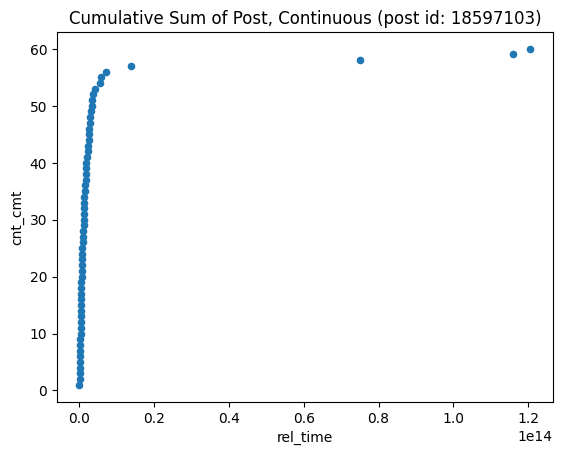

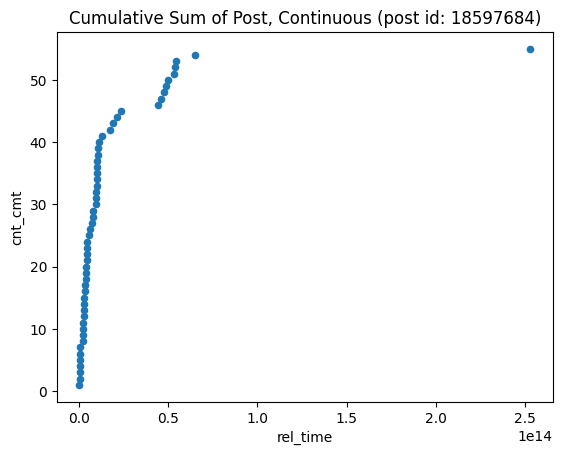

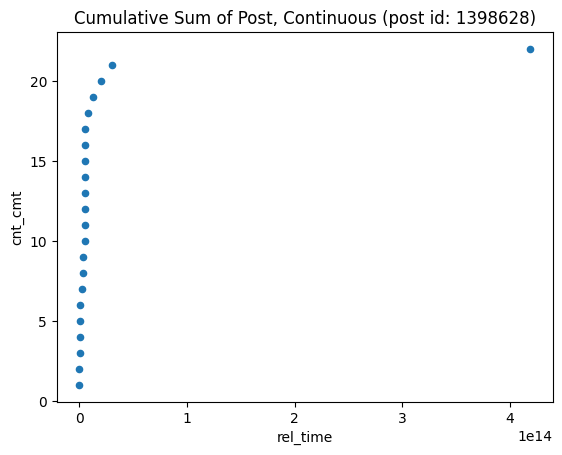

In [14]:
post_ids = [18597103, 18597684, 1398628]

for post_id in post_ids:
    post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
    post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
    post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
    plt.title(f"Cumulative Sum of Post, Continuous (post id: {post_id})")

## With Discrete Time (Applying Binning)

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_82626/356184318.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



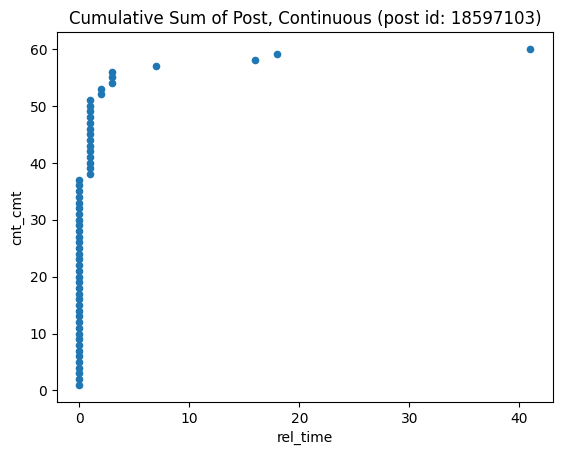

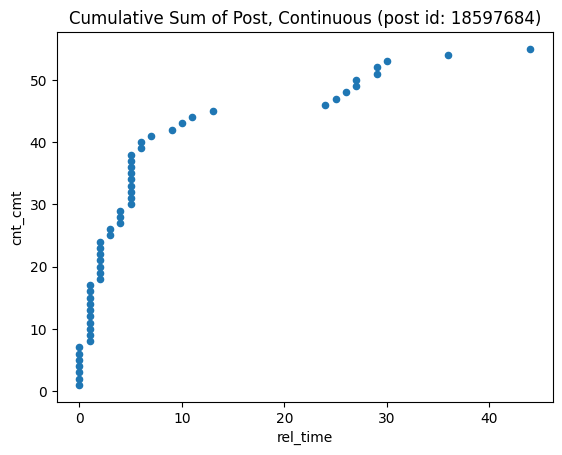

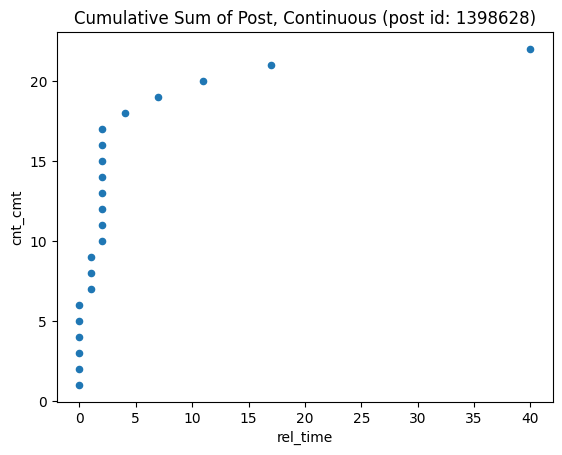

In [15]:
hot_post_df['rel_time'] = hot_post_df['rel_time'].apply(timedelta_to_seconds) // (30*60) # applying binnig (30 minutes)

post_ids = [18597103, 18597684, 1398628]
for post_id in post_ids:
    post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
    post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
    post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
    plt.title(f"Cumulative Sum of Post, Continuous (post id: {post_id})")